#Antenna Effects Demonstration

In [1]:
%matplotlib inline
import evillens as evil
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from operator import mul

A demonstration of the saboteur module in EvilLens.  In this notebook, we are going to use the saboteur to read a measurement set (a set of data as would be produce by a facility such as ALMA), and add realistic observational effects to the measurements.  For our purposes, we are going to focus on three different types of observational effects:  Decoherence, Antenna Amplitude Errors, and Antenna Phase Errors.  

We start by creating a saboteur object.  To do so, one must specify two numbers.  The first is the constant K, which is used to
determine the rms phase fluctuations (important for determining phase errors and decoherence).  K is related to the amount of water vapor in the atmosphere, and is of order 100 on a normal day at the ALMA site (Chajnantor).  The second number is the wavelength at which the observation is taken.  Currently, this parameter is specified, but it may be possible for this parameter (and even K) to be read from a measurment set along with the data.

We then read a measurement set from CASA.  This calls the drive_casa software (Staley et al. 2015 (in Prep)).  When calling this function, a user must specify the location of the measurement set, as well as the name of the alma configuration file that the set was created with (just the file name, the code will automatically seek out it's location).  We are also going to make copies of the visibilities, stored in the array Visibilities_old.  This copy will be used to compare the visibilities before and after observational effects have been added.

In [21]:
saboteur = evil.Saboteur(150.0,0.001)
saboteur.read_data_from('/Users/wmorning/research/data/HugoDrax_small_new/HugoDrax_small_new.alma.out20.ms', 'alma.out20.cfg')
Visibilities_old = np.copy(saboteur.Visibilities)

Below, we plot the U-V coverage, and the U-V distance Vs. magnitude of the visibilities.  The colors indicate the first antenna involved in the measurement.

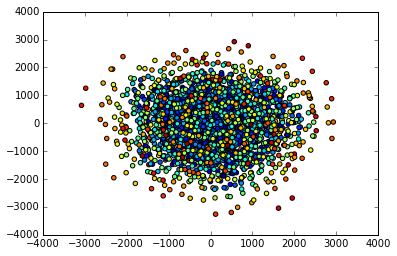

In [3]:
plt.scatter(saboteur.u,saboteur.v, c=saboteur.antenna1)

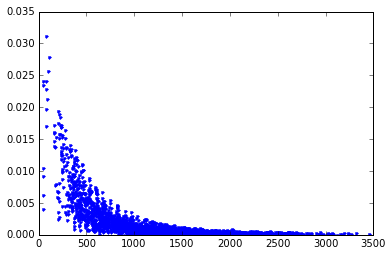

In [4]:
plt.plot(np.sqrt(saboteur.u**2+saboteur.v**2),np.sqrt(saboteur.Visibilities.real**2+saboteur.Visibilities.imag**2), 'b.')

Now lets examine adding amplitude errors and decoherence.  We will first focus on adding decoherence.  In interferometry, time averaging of phase variations (which occur due to differences in the light path length as a result of water in the atmosphere) causes the magnitude of the visibilities to be suppressed by a factor 
\begin{equation} <V> = V_0 \times <\exp{i \phi}> = V_0 \times \exp{\phi_{rms}^{2}/2} 
\end{equation}
(equation 4 from Carilli & Holdaway (1999) ), if we assume gaussian random phase fluctuations.  The rms phase fluctuation ($\phi_{rms}$) is determined from the root phase structure function
\begin{equation} \phi_{rms} = \frac{K}{\lambda_{mm}}b_{km}^{\alpha}~deg
\end{equation}, as predicted by Kolmogorov turbulence theory (Carilli & Holdaway (1999)).  The exponent $\alpha$ is related to the baseline length.  Kolmogorov Turbulence theory (Coulman 1990) predicts $\alpha=\frac{1}{3}$ for short baselines (shorter than the width of the turbulent layer of the atmosphere), and $\alpha=5/6$ for baselines longer than the width of the turbulent layer, but shorter than the 'outer scale' length $L_0$, above which the phase variations should be constant (Carilli & Holdaway 1999).

Thus, when the add_decoherence function is called, it calculates $\phi_{rms}$ for each baseline separation ($b=$\sqrt{u^{2}+v^{2}}$), and multiplies the corresponding visibility by the supression factor.  The results are plotted below.  Evidently the effect of decoherence is to reduce the amplitude of the signal from long baselines.

(0, 1550)

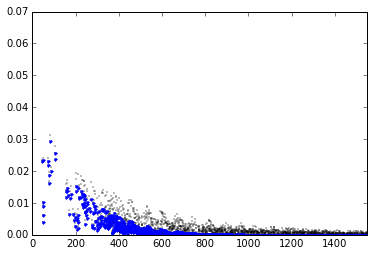

In [5]:
plt.scatter(np.sqrt(saboteur.u**2+saboteur.v**2),np.sqrt(Visibilities_old.real**2+Visibilities_old.imag**2),s=0.1, c='black')
saboteur.add_decoherence()

plt.plot(np.sqrt(saboteur.u**2+saboteur.v**2),np.sqrt(saboteur.Visibilities.real**2+saboteur.Visibilities.imag**2),'b.')
plt.ylim(0,0.07)
plt.xlim(0,1550)

Next we are going to add amplitude errors.  Amplitude errors are simple, because they are independent of baseline separation or the position of the antenna.  For an amplitude error, we just assume that at some observation time, the amplitude of one of the antennas is multiplied by factor of order unity.  To add amplitude errors to data using the saboteur, the only parameter that need be specified is the width of the distribution of amplitude errors.  The function then draws N random numbers from a normal distribution with mean 1.0, and width as specified, where N is the number of Antennas in the specific ALMA configuration (which was obtained when loading the measurement set).  It then multiplies each visibility by the drawn random numbers associated with both antennas making the measurement.  A more sophisticated treatment might allow for time dependant amplitude fluctuations, which would be easy to add.

Below we have plotted the visibilities before (black) and after (blue) amplitude errors were added.  Note that the scatter of the data points has increased significantly.  It is important to note here that we used a large width of the amplitude fluctuations to highlight the effects; realistic amplitude errors will likely be smaller.

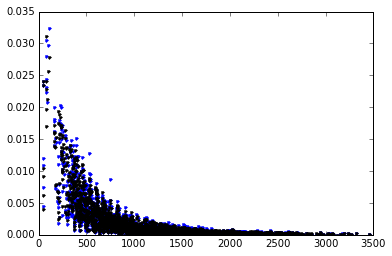

In [6]:
saboteur.Visibilities = np.copy(Visibilities_old)

saboteur.add_amplitude_errors(0.15)   #used a large value to highlight effects
plt.plot(np.sqrt(saboteur.u**2+saboteur.v**2),np.sqrt(saboteur.Visibilities.real**2+saboteur.Visibilities.imag**2), 'b.')
plt.plot(np.sqrt(saboteur.u**2+saboteur.v**2),np.sqrt(Visibilities_old.real**2+Visibilities_old.imag**2), 'k.')

Adding amplitude errors and decoherence seems to be fairly straightforward.  Phase errors are more complicated, since it depends on the absolute position of both antennas.  From before, we have that the root phase structure function is 
$\phi_{rms}=\frac{K}{\lambda}(b in km)^{\alpha}~(deg)$, 
where K is a constant, and b is the baseline distance.  This function determines the rms phase difference between two antennas,
as a function of their separation and the other parameters of the observation.  

However, modeling the phases themselves, in a large population of antennas is slightly more complicated, since all antennas should measure the same phase structure function, independent of their location in the array.  Moreover, the phase error on an individual antenna should influence all of the observations taken using that antenna by the same amount.  Thus we use fourier transforms to produce a phase screen that follows the root phase structure function at all points in the grid.  We also want to make this time dependent, since we know that the atmosphere is dynamic and changes significantly over the course of a several hour observation.  Thus we have added an additional parameter (v, with units of meters/time step) when calling the add_phase_errors function, which specifies the velocity of the antennas relative to the phase screen.  For simplicity, the velocity is constant and always in the x-direction, however it is simple to allow it to move in any direction.

The function then determines new x,y coordinates of the antennas by shifting their position by $v\times N_{tstep}$, where 
$N_{tstep}$ is the number of time steps since the start of the observation.  To get this number, we exploit the fact that a measurement set is listed chronologically, that is to say, all of the integrations that were taken at the same time are listed together.  We can thus calculate $N_{tsteps}$ by integer dividing the row number (r) by the number of visibilities per time step ($N_{ant}(N_{ant}-1)$), ($N_{tsteps}=r/(N_{ant}(N_{ant}-1))$) 

From here the procedure of adding phase errors is as follows:

1) Create a grid of gaussian random phases from a normal distribution centered around 0 with width 1.0 (width could be changed if need be)

2) Take the fourier transform of this grid.  This gives us the same phase screen in frequency space.  Because of this, we must also make sure to obtain the corresponding frequency coordinates ($k_x$,$k_y$) for each point using the fft.fftfreq function in numpy (and the appropriate scaling).
   
3) For each point in the fourier transformed grid, multiply the value of that point by the square root of the power spectrum.  The power spectrum follows the form $P(k) = \frac{K\pi\sqrt{0.0365}}{180\lambda}(|\vec{k}|~in~km^{-1})^{\gamma} $ (Quirrenbach 2006, Saas fe advanced course 31), where $\gamma$ is -11/3 for the 3-dimensional turbulent regime (baselines shorter than ~1km), -5/3 for the 2-dimensional inertial range, and 0 for frequencies corresponding to baselines longer than 6km (the size of the largest coherent structures.  Note that $P(k)$ may be just equal to 0 for long baselines).  This step scales the magnitude of phase fluctuations appropriately for different length scales.
   
4) Take the inverse fourier transform of the grid.  The result is a phase screen that follows the phase structure function regardless of location (although that is hard to show strongly, since the phase structure function is itself an average behavior).
   
5) Take the list of positions that were calculated earlier, and assign a phase to each antenna at that position using the corresponding point in the phase screen.
  
6) The visibilities will then be multiplied by a factor $\exp{\left(i(\phi_1-\phi_2)\right)}$ where the two phases are the respective phases for each antenna involved with taking the observation.

Below we show the results of calling this function.  We have plotted the magnitudes of the visibilities alongside the original magnitudes.  As might be expected, the magnitude of the visibilities is unchanged by a rotation in the complex plane.  Thus, we also plotted the real components of the visibilities for both before (black) and after (blue).  In this second plot, the effect of the phase errors becomes apparent.

In [22]:
saboteur.Visibilities = np.copy(Visibilities_old)
saboteur.add_phase_errors(v=2440.0)

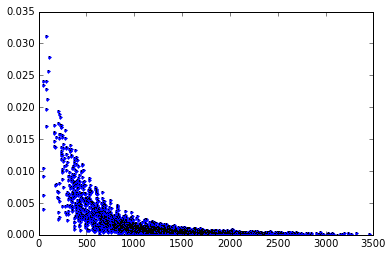

In [17]:
plt.plot(np.sqrt(saboteur.u**2+saboteur.v**2),np.sqrt(saboteur.Visibilities.real**2+saboteur.Visibilities.imag**2), 'b.')
plt.plot(np.sqrt(saboteur.u**2+saboteur.v**2),np.sqrt(Visibilities_old.real**2+Visibilities_old.imag**2),'k,')

(-0.005, 0.005)

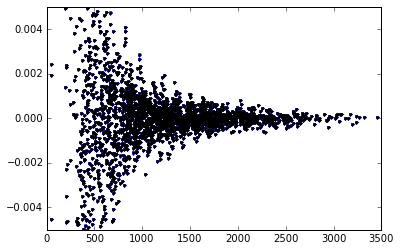

In [18]:
plt.plot(np.sqrt(saboteur.u**2+saboteur.v**2),(saboteur.Visibilities).real, 'b.')
plt.plot(np.sqrt(saboteur.u**2+saboteur.v**2),Visibilities_old.real, 'k.')

plt.ylim(-0.005,0.005)

Also, to show the phase screen that is created, we have plotted it below.  The extent of the screen extends beyond the axis limits of the figure slightly.  Aditionally, we have overplotted the locations of the antennas at the different time steps.  Note that they appear to be moving in the x-direction.  The colorbar to the side of the figure shows the magnitude of the phase error at each point.  Note that the phases can fluctuate up to over 1 radian for the longest baselines. 

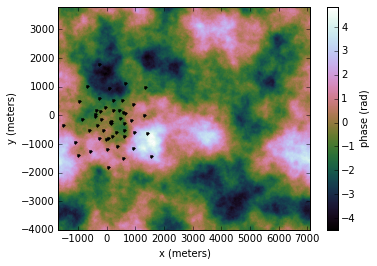

In [25]:
plt.imshow(saboteur.phases.real,cmap='cubehelix',extent=(np.min(saboteur.phasecoords_x),np.max(saboteur.phasecoords_x),np.min(saboteur.phasecoords_y),np.max(saboteur.phasecoords_y)))
cbar = plt.colorbar()
cbar.set_label('phase (rad)')
plt.plot(saboteur.antennaX,saboteur.antennaY, 'k.')
plt.xlim(np.min(saboteur.phasecoords_x),np.max(saboteur.phasecoords_x))
plt.ylim(np.min(saboteur.phasecoords_y),np.max(saboteur.phasecoords_y))
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')

Finally, we must write our data back to a measurement set.  The function that we have created for this forms a copy of the measurement set called "OldMeasurementSetName_sabotaged.ms" in the same directory as the original measurement set.  It then calls CASA as before using Drive Casa, and writes the array of visibilities to the measurement set data.  Future renditions of this function should be able to handle multiwavelength data, and thus know where to write the sabotaged visibilities.  For now however, this module is limited to single band data.  To check that the data that we produce is sabotaged, we are going to write data with decoherence added using the add_decoherence function.

In [12]:
saboteur.add_decoherence()
saboteur.sabotage_measurement_set()

(['', '', '2015-05-06 22:35:25\tINFO\t\tInitializing with default selection', '', '', '', '', '', '', '', '', '', ''], [])


Now, let's load the sabotaged measurement set using another saboteur, and see if the sabotaged data was recorded properly.

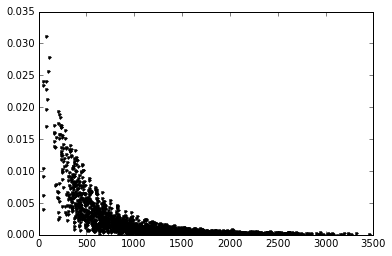

In [20]:
saboteur2 = evil.Saboteur(150.0,1.0)
saboteur2.read_data_from('/Users/wmorning/research/data/HugoDrax_small_new/HugoDrax_small_new.alma.out20_sabotaged.ms', 'alma.out20.cfg')
plt.plot(np.sqrt(saboteur2.u**2+saboteur2.v**2), np.sqrt(saboteur.Visibilities.real**2+saboteur.Visibilities.imag**2), 'k.')

Success!  The data written to the measurement set is indeed read back in the same form as it was written.